# **Tourism Recommendation**

## **Data Preparation (Kaggle)**

### **Dataset Summary**

This dataset is a dataset that contains several tourist attractions in 5 major cities in Indonesia, namely Jakarta, Yogyakarta, Semarang, Bandung, Surabaya. [Indonesia Tourism Destination](https://www.kaggle.com/datasets/aprabowo/indonesia-tourism-destination)

### **Kaggle Environment Variables**

In [1]:
# install library
import os
import pandas as pd

In [2]:
# API
os.environ['KAGGLE_USERNAME'] = 'nurmuhimawann'
os.environ['KAGGLE_KEY'] = '9ec72152f6aaf09a48de3697d930c08e'

In [3]:
# dataset
!kaggle datasets download -d aprabowo/indonesia-tourism-destination

100% 158k/158k [00:00<00:00, 637kB/s]
100% 158k/158k [00:00<00:00, 636kB/s]


In [4]:
# extract zip
!unzip indonesia-tourism-destination.zip -d /content/data

# remove unused files
os.remove('indonesia-tourism-destination.zip')

Archive:  indonesia-tourism-destination.zip
  inflating: /content/data/package_tourism.csv  
  inflating: /content/data/tourism_rating.csv  
  inflating: /content/data/tourism_with_id.csv  
  inflating: /content/data/user.csv  


## **Library**

In [5]:
#import library
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

## **Data Understanding**

In [6]:
# data path
package = pd.read_csv('/content/data/package_tourism.csv')
tourism = pd.read_csv('/content/data/tourism_with_id.csv')
ratings = pd.read_csv('/content/data/tourism_rating.csv')
users = pd.read_csv('/content/data/user.csv')

# see the amount of data
print(f"Jumlah data paket wisata: {len(package.Package.unique())}")
print(f'Jumlah data tempat wisata: {len(tourism.Place_Id.unique())}')
print(f'Jumlah data rating tempat wisata: {len(ratings.User_Id.unique())}')
print(f'Jumlah data user: {len(users.User_Id.unique())}')

Jumlah data paket wisata: 100
Jumlah data tempat wisata: 437
Jumlah data rating tempat wisata: 300
Jumlah data user: 300


In [7]:
# see package
package.head(3)

,Package,City,Place_Tourism1,Place_Tourism2,Place_Tourism3,Place_Tourism4,Place_Tourism5
0,1,Jakarta,Pasar Tanah Abang,Taman Ayodya,Museum Tekstil,NaN,NaN
1,2,Jakarta,Pasar Tanah Abang,Pasar Taman Puring,Pasar Petak Sembilan,NaN,NaN
2,3,Jakarta,Perpustakaan Nasional,Monas,Masjid Istiqlal,NaN,NaN


In [8]:
# see tourism
tourism.head(3)

,Place_Id,Place_Name,Description,Category,City,Price,Rating,Time_Minutes,Coordinate,Lat,Long,Unnamed: 11,Unnamed: 12
0,1,Monumen Nasional,Monumen Nasional atau yang populer disingkat d...,Budaya,Jakarta,20000,4.6,15.0,"{'lat': -6.1753924, 'lng': 106.8271528}",-6.175392,106.827153,NaN,1
1,2,Kota Tua,"Kota tua di Jakarta, yang juga bernama Kota Tu...",Budaya,Jakarta,0,4.6,90.0,"{'lat': -6.137644799999999, 'lng': 106.8171245}",-6.137645,106.817125,NaN,2
2,3,Dunia Fantasi,Dunia Fantasi atau disebut juga Dufan adalah t...,Taman Hiburan,Jakarta,270000,4.6,360.0,"{'lat': -6.125312399999999, 'lng': 106.8335377}",-6.125312,106.833538,NaN,3


In [9]:
# see ratings
ratings.head(3)

,User_Id,Place_Id,Place_Ratings
0,1,179,3
1,1,344,2
2,1,5,5


In [10]:
# see users
users.head(3)

,User_Id,Location,Age
0,1,"Semarang, Jawa Tengah",20
1,2,"Bekasi, Jawa Barat",21
2,3,"Cirebon, Jawa Barat",23


I thought of creating a content-based and collaborative model, so I decided to use data tourism and ratings.

## **Data Preprocessing**

### **df_tourism**

In [11]:
# tourism information
tourism.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 437 entries, 0 to 436
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Place_Id      437 non-null    int64  
 1   Place_Name    437 non-null    object 
 2   Description   437 non-null    object 
 3   Category      437 non-null    object 
 4   City          437 non-null    object 
 5   Price         437 non-null    int64  
 6   Rating        437 non-null    float64
 7   Time_Minutes  205 non-null    float64
 8   Coordinate    437 non-null    object 
 9   Lat           437 non-null    float64
 10  Long          437 non-null    float64
 11  Unnamed: 11   0 non-null      float64
 12  Unnamed: 12   437 non-null    int64  
dtypes: float64(5), int64(3), object(5)
memory usage: 44.5+ KB


In [12]:
# drop unused features
tourism.drop(['Price', 'Rating', 'Time_Minutes', 'Coordinate', 'Lat', 'Long', 'Unnamed: 11', 'Unnamed: 12'], axis=1, inplace=True)
tourism.head()

,Place_Id,Place_Name,Description,Category,City
0,1,Monumen Nasional,Monumen Nasional atau yang populer disingkat d...,Budaya,Jakarta
1,2,Kota Tua,"Kota tua di Jakarta, yang juga bernama Kota Tu...",Budaya,Jakarta
2,3,Dunia Fantasi,Dunia Fantasi atau disebut juga Dufan adalah t...,Taman Hiburan,Jakarta
3,4,Taman Mini Indonesia Indah (TMII),Taman Mini Indonesia Indah merupakan suatu kaw...,Taman Hiburan,Jakarta
4,5,Atlantis Water Adventure,Atlantis Water Adventure atau dikenal dengan A...,Taman Hiburan,Jakarta


### **df_ratings**

In [13]:
# ratings information
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype
---  ------         --------------  -----
 0   User_Id        10000 non-null  int64
 1   Place_Id       10000 non-null  int64
 2   Place_Ratings  10000 non-null  int64
dtypes: int64(3)
memory usage: 234.5 KB


### **all_tourism**

In [14]:
# merging dataframes
all_tourism = pd.merge(ratings, tourism[['Place_Id', 'Place_Name', 'Category', 'Description', 'City']], on='Place_Id', how='left')
all_tourism.head()

,User_Id,Place_Id,Place_Ratings,Place_Name,Category,Description,City
0,1,179,3,Candi Ratu Boko,Budaya,Situs Ratu Baka atau Candi Boko (Hanacaraka:ꦕꦤ...,Yogyakarta
1,1,344,2,Pantai Marina,Bahari,"Pantai Marina (bahasa Jawa: ꦥꦱꦶꦱꦶꦂ​ꦩꦫꦶꦤ, trans...",Semarang
2,1,5,5,Atlantis Water Adventure,Taman Hiburan,Atlantis Water Adventure atau dikenal dengan A...,Jakarta
3,1,373,3,Museum Kereta Ambarawa,Budaya,Museum Kereta Api Ambarawa (bahasa Inggris: In...,Semarang
4,1,101,4,Kampung Wisata Sosro Menduran,Budaya,Kampung wisata Sosromenduran merupakan kampung...,Yogyakarta


In [15]:
# see information
all_tourism.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 0 to 9999
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   User_Id        10000 non-null  int64 
 1   Place_Id       10000 non-null  int64 
 2   Place_Ratings  10000 non-null  int64 
 3   Place_Name     10000 non-null  object
 4   Category       10000 non-null  object
 5   Description    10000 non-null  object
 6   City           10000 non-null  object
dtypes: int64(3), object(4)
memory usage: 625.0+ KB


## **Exploratory Data Analysis**

<Axes: xlabel='Place_Ratings', ylabel='count'>

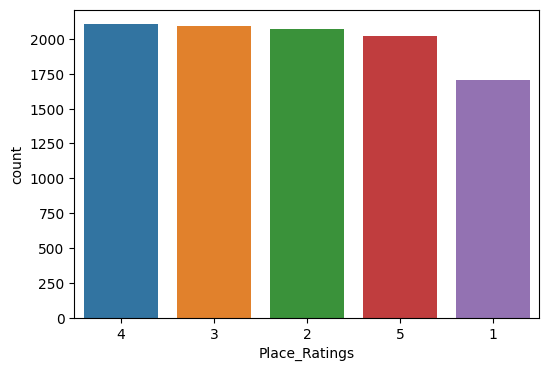

In [16]:
# countplot place_ratings
plt.figure(figsize=(6, 4))
sns.countplot(x=all_tourism['Place_Ratings'], data=all_tourism, order=all_tourism['Place_Ratings'].value_counts().index)

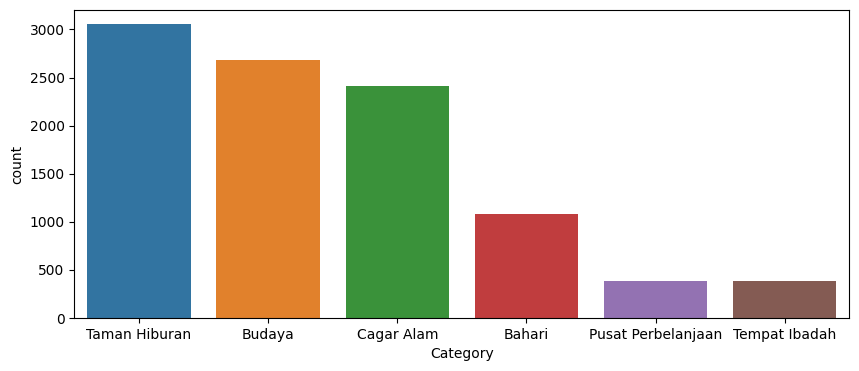

In [17]:
# countplot category
plt.figure(figsize=(10, 4))
ax = sns.countplot(x=all_tourism['Category'], data=all_tourism, order=all_tourism['Category'].value_counts().index)

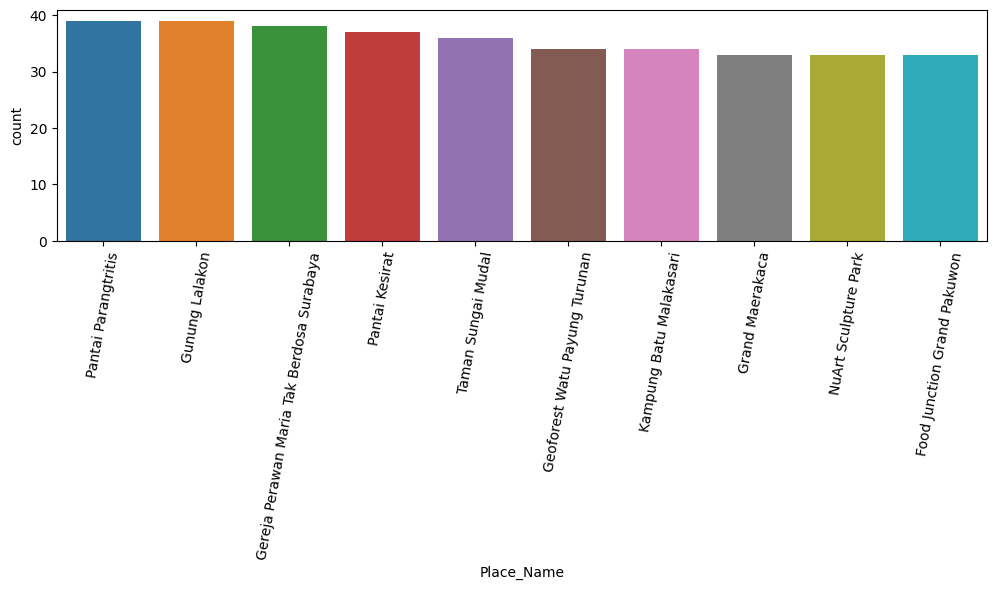

In [18]:
# countplot places
plt.figure(figsize=(12, 3))
top_10_places = all_tourism['Place_Name'].value_counts().nlargest(10).index
ax = sns.countplot(x=all_tourism['Place_Name'], data=all_tourism, order=top_10_places)
plt.xticks(rotation=80)
plt.show()

## **Data Cleaning**

In [19]:
# find duplicate values
all_tourism.isnull().sum()

User_Id          0
Place_Id         0
Place_Ratings    0
Place_Name       0
Category         0
Description      0
City             0
dtype: int64

In [20]:
# count places
len(all_tourism.Place_Id.unique())

437

In [21]:
# sort
preparation = all_tourism
preparation_cf = all_tourism
preparation.sort_values('Place_Id').head()

,User_Id,Place_Id,Place_Ratings,Place_Name,Category,Description,City
6236,187,1,4,Monumen Nasional,Budaya,Monumen Nasional atau yang populer disingkat d...,Jakarta
5348,162,1,5,Monumen Nasional,Budaya,Monumen Nasional atau yang populer disingkat d...,Jakarta
5610,169,1,5,Monumen Nasional,Budaya,Monumen Nasional atau yang populer disingkat d...,Jakarta
2089,64,1,2,Monumen Nasional,Budaya,Monumen Nasional atau yang populer disingkat d...,Jakarta
5231,159,1,1,Monumen Nasional,Budaya,Monumen Nasional atau yang populer disingkat d...,Jakarta


In [22]:
# dataframes shape
preparation.shape

(10000, 7)

drop duplicate data by place_id

In [23]:
# drop duplicated
preparation = preparation.drop_duplicates('Place_Id')
preparation.head()

,User_Id,Place_Id,Place_Ratings,Place_Name,Category,Description,City
0,1,179,3,Candi Ratu Boko,Budaya,Situs Ratu Baka atau Candi Boko (Hanacaraka:ꦕꦤ...,Yogyakarta
1,1,344,2,Pantai Marina,Bahari,"Pantai Marina (bahasa Jawa: ꦥꦱꦶꦱꦶꦂ​ꦩꦫꦶꦤ, trans...",Semarang
2,1,5,5,Atlantis Water Adventure,Taman Hiburan,Atlantis Water Adventure atau dikenal dengan A...,Jakarta
3,1,373,3,Museum Kereta Ambarawa,Budaya,Museum Kereta Api Ambarawa (bahasa Inggris: In...,Semarang
4,1,101,4,Kampung Wisata Sosro Menduran,Budaya,Kampung wisata Sosromenduran merupakan kampung...,Yogyakarta


In [24]:
# dataframes shape
preparation.shape

(437, 7)

In [25]:
# Convert data series ‘Place_Id’ to list form
place_id = preparation['Place_Id'].tolist()

# Convert data series ‘Place_Name’ to list form
place_name = preparation['Place_Name'].tolist()

# Convert data series ‘Category’ to list form
place_category = preparation['Category'].tolist()

# count
print(len(place_id))
print(len(place_name))
print(len(place_category))

437
437
437


In [26]:
# Create dataframe tourism using dict form of ‘Place_Id’, ‘Place_Name’, and ‘Category’
df_tourism = pd.DataFrame({
    'place_id' : place_id,
    'place_name' : place_name,
    'place_category' : place_category
})

df_tourism.head()

,place_id,place_name,place_category
0,179,Candi Ratu Boko,Budaya
1,344,Pantai Marina,Bahari
2,5,Atlantis Water Adventure,Taman Hiburan
3,373,Museum Kereta Ambarawa,Budaya
4,101,Kampung Wisata Sosro Menduran,Budaya


## **Model Development**

### **Data Modelling - Content-Based Filtering**

In [27]:
# sample
data = df_tourism
data.sample(5)

,place_id,place_name,place_category
311,165,Green Village Gedangsari,Taman Hiburan
368,221,Museum Geologi Bandung,Budaya
19,76,Taman Cattleya,Taman Hiburan
70,131,Watu Lumbung,Cagar Alam
295,182,Hutan Mangrove Kulon Progo,Bahari


**TF-IDF Vectorizer**

In [28]:
# create object TfidfVectorizer
tf = TfidfVectorizer()

# idf
tf.fit(data['place_category'])

# mapping array
tf.get_feature_names_out()

array(['alam', 'bahari', 'budaya', 'cagar', 'hiburan', 'ibadah',
       'perbelanjaan', 'pusat', 'taman', 'tempat'], dtype=object)

Membuat sistem rekomendasi berdasarkan tempat wisata yang telah dikunjungi sebelummnya, menggunakan TF-IDF Vectorizer dengan fungsi `tfidfvectorizer()` dari sklearn. Tahap ini terdiri dari inisialisasi TfidfVectorizer, kemudian perhitungan idf pada place_name dan mapping array dari fitur index ke fitur nama.

In [29]:
# fit & transform to matrix
tfidf_matrix = tf.fit_transform(data['place_category'])
 
# show matrix dimension
tfidf_matrix.shape 

(437, 10)

In [30]:
# change tf-idf vector to matrix form
tfidf_matrix.todense()

matrix([[0.        , 0.        , 1.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 1.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.70710678,
         0.        ],
        ...,
        [0.        , 1.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.70710678, 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.70710678,
         0.        ]])

In [31]:
# dataframe tf-idf matrix, row: place_name, columns: place_category
pd.DataFrame(
    tfidf_matrix.todense(), 
    columns=tf.get_feature_names_out(),
    index=data.place_name
).sample(10, axis=1).sample(10, axis=0)

,bahari,alam,budaya,cagar,ibadah,tempat,perbelanjaan,hiburan,taman,pusat
place_name,,,,,,,,,,
Pantai Ria Kenjeran,1.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0
Pantai Drini,1.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0
Curug Cimahi,0.0,0.707107,0.0,0.707107,0.000000,0.000000,0.0,0.000000,0.000000,0.0
Sam Poo Kong Temple,0.0,0.000000,1.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0
Gereja Katedral Santo Petrus Bandung,0.0,0.000000,0.0,0.000000,0.707107,0.707107,0.0,0.000000,0.000000,0.0
Museum Benteng Vredeburg Yogyakarta,0.0,0.000000,1.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0
Kampoeng Kopi Banaran,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.707107,0.707107,0.0
Pantai Depok Jogja,1.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0
Museum Nike Ardilla,0.0,0.000000,1.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0


Yeay, from here we have got a representation of the important features of each category.

**Cosine Similarity**

In [32]:
# calculate cosine similarity on matrix
cosine_sim = cosine_similarity(tfidf_matrix) 
cosine_sim

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 1., 0., 0.],
       [0., 0., 1., ..., 0., 0., 1.],
       ...,
       [0., 1., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 1., ..., 0., 0., 1.]])

In [33]:
# create dataframe from the results of cosine similarity
cosine_sim_df = pd.DataFrame(cosine_sim, index=data['place_name'], columns=data['place_name'])
print('Shape:', cosine_sim_df.shape)
 
# show similarity matrix
cosine_sim_df.sample(5, axis=1).sample(10, axis=0)

Shape: (437, 437)


place_name,Setu Babakan,Geoforest Watu Payung Turunan,Taman Prestasi,Pantai Pulang Sawal,Galaxy Waterpark Jogja
place_name,,,,,
Taman Sungai Mudal,0.0,1.0,0.0,0.0,0.0
Kota Tua,1.0,0.0,0.0,0.0,0.0
Gunung Papandayan,0.0,1.0,0.0,0.0,0.0
Pantai Jungwok,0.0,0.0,0.0,1.0,0.0
Pantai Ngobaran,0.0,0.0,0.0,1.0,0.0
Candi Sewu,1.0,0.0,0.0,0.0,0.0
Taman Ismail Marzuki,1.0,0.0,0.0,0.0,0.0
Desa Wisata Gamplong,0.0,0.0,1.0,0.0,1.0
Monumen Tugu Pahlawan,1.0,0.0,0.0,0.0,0.0


In [34]:
#fungsi untuk rekomendasi
def tourism_recommendations(nama_tempat, similarity_data = cosine_sim_df, items = data[['place_name', 'place_category']], k = 5) :
  index = similarity_data.loc[:, nama_tempat].to_numpy().argpartition(
      range(-1, -k, -1)
  )

  closest = similarity_data.columns[index[-1:-(k+2):-1]]
  closest = closest.drop(nama_tempat, errors = 'ignore')

  return pd.DataFrame(closest).merge(items).head(k)

In [35]:
# function recommendations
def tourism_recommendations(place_name, similarity_data=cosine_sim_df, items=data[['place_name', 'place_category']], k=5): 
    # get index
    index = similarity_data.loc[:,place_name].to_numpy().argpartition(
        range(-1, -k, -1))
    
    # retrieve data from an existing index
    closest = similarity_data.columns[index[-1:-(k+2):-1]]
    
    # drop place_name you want to search
    closest = closest.drop(place_name, errors='ignore')
 
    return pd.DataFrame(closest).merge(items).head(k)

In [36]:
# sample data
df_sample = data.sample(1)
df_sample

,place_id,place_name,place_category
294,375,Kota Lama Semarang,Budaya


In [37]:
# extract sample
df_sample = df_sample.reset_index(drop=True)
place_sample = df_sample.loc[0, 'place_name']
place_sample

'Kota Lama Semarang'

In [38]:
# get recommendations
tourism_recommendations(place_sample)

,place_name,place_category
0,Candi Ratu Boko,Budaya
1,Museum Nike Ardilla,Budaya
2,Istana Negara Republik Indonesia,Budaya
3,Jalan Braga,Budaya
4,Museum Benteng Vredeburg Yogyakarta,Budaya


Yeayyy, Congrats. this is recommendation for you.

### **Data Modelling - Collaborative Filtering**

In [39]:
df = preparation_cf
df.head()

,User_Id,Place_Id,Place_Ratings,Place_Name,Category,Description,City
0,1,179,3,Candi Ratu Boko,Budaya,Situs Ratu Baka atau Candi Boko (Hanacaraka:ꦕꦤ...,Yogyakarta
1,1,344,2,Pantai Marina,Bahari,"Pantai Marina (bahasa Jawa: ꦥꦱꦶꦱꦶꦂ​ꦩꦫꦶꦤ, trans...",Semarang
2,1,5,5,Atlantis Water Adventure,Taman Hiburan,Atlantis Water Adventure atau dikenal dengan A...,Jakarta
3,1,373,3,Museum Kereta Ambarawa,Budaya,Museum Kereta Api Ambarawa (bahasa Inggris: In...,Semarang
4,1,101,4,Kampung Wisata Sosro Menduran,Budaya,Kampung wisata Sosromenduran merupakan kampung...,Yogyakarta


In [40]:
# change unique values of 'User_Id' to list
user_ids = df['User_Id'].unique().tolist()
print('list User_Id: ', user_ids)
 
# encode 'User_Id'
user_to_user_encoded = {x: i for i, x in enumerate(user_ids)}
print('encoded User_Id : ', user_to_user_encoded)
 
# encoding index to 'User_Id'
user_encoded_to_user = {i: x for i, x in enumerate(user_ids)}
print('encoded angka ke User_Id: ', user_encoded_to_user)

list User_Id:  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 21

In [41]:
# change unique values of 'Place_Id' to list
place_ids = df['Place_Id'].unique().tolist()
print('list Place_Id : ', place_ids)

# encode 'Place_Id'
place_to_place_encoded = {x: i for i, x in enumerate(place_ids)}
print('encoded Place_Id : ', place_to_place_encoded)

# encoding index to 'Place_Id'
place_encoded_to_place = {i: x for i, x in enumerate(place_ids)}
print('encoded angka ke Place_Id : ', place_encoded_to_place)

list Place_Id :  [179, 344, 5, 373, 101, 312, 258, 20, 154, 393, 103, 208, 89, 405, 41, 336, 67, 292, 222, 76, 428, 15, 246, 265, 21, 328, 307, 302, 48, 147, 2, 322, 23, 85, 371, 78, 111, 107, 185, 413, 389, 437, 105, 176, 407, 281, 167, 384, 426, 390, 367, 166, 18, 321, 262, 223, 17, 319, 310, 421, 202, 283, 250, 118, 54, 70, 33, 227, 86, 249, 131, 382, 193, 104, 24, 128, 134, 228, 237, 100, 198, 50, 376, 268, 242, 82, 348, 409, 88, 4, 377, 43, 91, 44, 14, 406, 383, 229, 290, 294, 309, 74, 97, 138, 436, 395, 300, 68, 55, 434, 9, 151, 61, 159, 397, 391, 301, 143, 27, 190, 346, 381, 368, 433, 420, 335, 115, 334, 219, 178, 266, 92, 64, 102, 257, 243, 116, 359, 121, 385, 398, 119, 298, 410, 224, 379, 255, 269, 213, 126, 192, 183, 129, 303, 296, 99, 148, 13, 247, 31, 77, 158, 306, 98, 235, 45, 173, 275, 25, 130, 164, 267, 56, 30, 238, 402, 196, 417, 304, 206, 211, 28, 264, 403, 253, 331, 188, 416, 378, 233, 95, 204, 225, 341, 145, 36, 168, 12, 280, 236, 42, 90, 75, 63, 205, 234, 284, 230, 

In [42]:
# Mapping 'userId' to dataframe
df['user'] = df['User_Id'].map(user_to_user_encoded)
 
# Mapping 'Place_Id' ke dataframe
df['place'] = df['Place_Id'].map(place_to_place_encoded)

In [43]:
# get number of users
num_users = len(user_to_user_encoded)
print(num_users)

# get number of films
num_places = len(place_encoded_to_place)
print(num_places)

# change dtype
df.loc[:, 'Place_Ratings'] = df['Place_Ratings'].astype(np.float32)

# get min values of rating
min_rating = min(df['Place_Ratings'])

# get max values of rating
max_rating = max(df['Place_Ratings'])

print('Number of User : {}, Number of Place : {}, Min Rating {}, Max Rating {}'.format(
    num_users, num_places, min_rating, max_rating
))

300
437
Number of User : 300, Number of Place : 437, Min Rating 1.0, Max Rating 5.0


<ipython-input-43-a620b2d94920>:10: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df.loc[:, 'Place_Ratings'] = df['Place_Ratings'].astype(np.float32)


**Split Data for Training and Validation**

In [44]:
# sampling
df = df.sample(frac=1, random_state=42)
df.head()

,User_Id,Place_Id,Place_Ratings,Place_Name,Category,Description,City,user,place
6252,188,207,3.0,Heha Sky View,Taman Hiburan,HeHa Sky View adalah salah satu tempat wisata ...,Yogyakarta,187,262
4684,142,268,2.0,Sudut Pandang Bandung,Taman Hiburan,Sudut Pandang Cafe Bandung merupakan sebuah de...,Bandung,141,83
1731,54,103,3.0,Tugu Pal Putih Jogja,Taman Hiburan,"Tugu Yogyakarta (Jawa: , Tugu Ngayogyakarta) a...",Yogyakarta,53,10
4742,144,119,3.0,Lava Bantal,Budaya,Wilayah DIY menawarkan sejumlah potensi wisata...,Yogyakarta,143,141
4521,138,288,5.0,Masjid Salman ITB,Tempat Ibadah,Masjid Salman ITB adalah masjid kampus yang te...,Bandung,137,283


In [45]:
# mapping users and films data into one value
x = df[['user', 'place']].values

# ratings
y = df['Place_Ratings'].apply(lambda x: (x - min_rating) / (max_rating - min_rating)).values

# split data train and validation with 80/20 composition
train_indices = int(0.8 * df.shape[0])
x_train, x_val, y_train, y_val = (
    x[:train_indices],
    x[train_indices:],
    y[:train_indices],
    y[train_indices:]
)

print(x, y)

[[187 262]
 [141  83]
 [ 53  10]
 ...
 [162  52]
 [ 27 187]
 [218   6]] [0.5  0.25 0.5  ... 0.5  0.75 0.25]


**Training**

In [46]:
# library
import tensorflow as tf

# class recommendations
class RecommenderNet(tf.keras.Model):
 
  def __init__(self, num_users, num_places, embedding_size, **kwargs):
    super(RecommenderNet, self).__init__(**kwargs)
    self.num_users = num_users
    self.num_places = num_places
    self.embedding_size = embedding_size
    self.user_embedding = tf.keras.layers.Embedding( # layer embedding user
        num_users,
        embedding_size,
        embeddings_initializer = 'he_normal',
        embeddings_regularizer = tf.keras.regularizers.l2(1e-6)
    )

    self.user_bias = tf.keras.layers.Embedding(num_users, 1) # layer embedding user bias
    self.places_embedding = tf.keras.layers.Embedding( # layer embeddings places
        num_places,
        embedding_size,
        embeddings_initializer = 'he_normal',
        embeddings_regularizer = tf.keras.regularizers.l2(1e-6)
    )
    self.places_bias = tf.keras.layers.Embedding(num_places, 1) # layer embedding places bias
  
  def call(self, inputs) :
    user_vector = self.user_embedding(inputs[:, 0]) # layer embedding 1
    user_bias = self.user_bias(inputs[:, 0]) # layer embedding 2
    places_vector = self.places_embedding(inputs[:, 1]) # layer embedding 3
    places_bias = self.places_bias(inputs[:, 1]) # layer embedding 4

    dot_user_places = tf.tensordot(user_vector, places_vector, 2)

    x = dot_user_places + user_bias + places_bias

    return tf.nn.sigmoid(x) # activation sigmoid

In [47]:
# model initialization
model = RecommenderNet(num_users, num_places, 50)

# model compile
model.compile(
    loss = tf.keras.losses.BinaryCrossentropy(),
    optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001),
    metrics = [tf.keras.metrics.RootMeanSquaredError()]
)

In [48]:
# training
history = model.fit(
    x = x_train,
    y = y_train,
    batch_size = 32,
    epochs = 100,
    validation_data = (x_val, y_val)
)

Epoch 1/100
250/250 [==============================] - 15s 24ms/step - loss: 0.7000 - root_mean_squared_error: 0.3501 - val_loss: 0.6972 - val_root_mean_squared_error: 0.3478
Epoch 2/100
250/250 [==============================] - 2s 8ms/step - loss: 0.6989 - root_mean_squared_error: 0.3493 - val_loss: 0.6976 - val_root_mean_squared_error: 0.3481
Epoch 3/100
250/250 [==============================] - 2s 9ms/step - loss: 0.6957 - root_mean_squared_error: 0.3470 - val_loss: 0.6973 - val_root_mean_squared_error: 0.3478
Epoch 4/100
250/250 [==============================] - 1s 5ms/step - loss: 0.6915 - root_mean_squared_error: 0.3441 - val_loss: 0.6979 - val_root_mean_squared_error: 0.3483
Epoch 5/100
250/250 [==============================] - 1s 4ms/step - loss: 0.6901 - root_mean_squared_error: 0.3431 - val_loss: 0.6975 - val_root_mean_squared_error: 0.3480
Epoch 6/100
250/250 [==============================] - 1s 4ms/step - loss: 0.6927 - root_mean_squared_error: 0.3447 - val_loss: 0.698

**Metric Visualization**

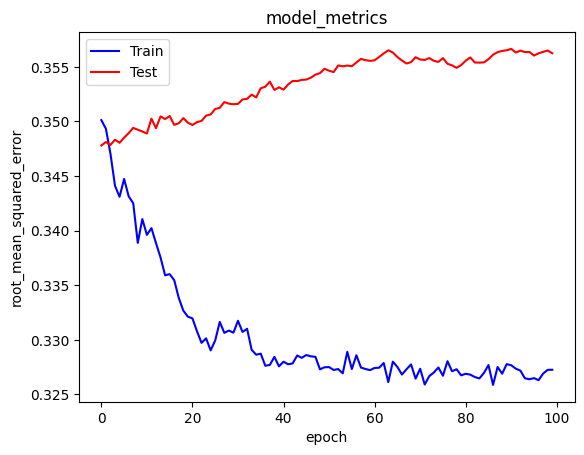

In [49]:
# plot metrics evaluations
plt.plot(history.history['root_mean_squared_error'], color='blue')
plt.plot(history.history['val_root_mean_squared_error'], color='red')
plt.title('model_metrics')
plt.ylabel('root_mean_squared_error')
plt.xlabel('epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

**Get Recommendations**

In [50]:
# ratings
df_ratings = ratings
df_ratings['Place_Ratings'] = df_ratings['Place_Ratings'].values.astype(np.float32)
df_ratings.head()

,User_Id,Place_Id,Place_Ratings
0,1,179,3.0
1,1,344,2.0
2,1,5,5.0
3,1,373,3.0
4,1,101,4.0


In [51]:
# places
df_places = df_tourism
df_places.head()

,place_id,place_name,place_category
0,179,Candi Ratu Boko,Budaya
1,344,Pantai Marina,Bahari
2,5,Atlantis Water Adventure,Taman Hiburan
3,373,Museum Kereta Ambarawa,Budaya
4,101,Kampung Wisata Sosro Menduran,Budaya


In [52]:
# taking user samples
user_id = df_ratings.User_Id.sample(1).iloc[0]
places_visited_by_user = df_ratings[df_ratings.User_Id == user_id]

# bitwise operators (~), can be found here https://docs.python.org/3/reference/expressions.html
places_not_visited = df_places[~df_places['place_id'].isin(places_visited_by_user.Place_Id.values)]['place_id']
places_not_visited = list(
    set(places_not_visited)
    .intersection(set(place_to_place_encoded.keys()))
)

places_not_visited = [[place_to_place_encoded.get(x)] for x in places_not_visited]
user_encoder = user_to_user_encoded.get(user_id)
user_places_array = np.hstack(
    ([[user_encoder]] * len(places_not_visited), places_not_visited)
)

In [53]:
# get recommendations
ratings = model.predict(user_places_array).flatten()

top_ratings_indices = ratings.argsort()[-10:][::-1]
recommended_places_ids = [
    place_encoded_to_place.get(places_not_visited[x][0]) for x in top_ratings_indices
]

print('Showing recommendations for users : {}'.format(user_id))
print('===' * 9)
print('Place with high ratings from user')
print('----' * 8)

top_places_user = (
    places_visited_by_user.sort_values(
        by = 'Place_Ratings',
        ascending=False
    )
    .head(5)
    .Place_Id.values
)
 
places_df_rows = df_places[df_places['place_id'].isin(top_places_user)]
for row in places_df_rows.itertuples():
  print(row.place_name, ':', row.place_category)

print('----' * 8)
print('Top 10 place recommendation')
print('----' * 8)

recommended_places = df_places[df_places['place_id'].isin(recommended_places_ids)]
for row in recommended_places.itertuples():
  print(row.place_name, ':', row.place_category)

13/13 [==============================] - 0s 2ms/step
Showing recommendations for users : 238
Place with high ratings from user
--------------------------------
Curug Malela : Cagar Alam
Taman Hiburan Rakyat : Taman Hiburan
Taman Spathodea : Taman Hiburan
Puncak Kebun Buah Mangunan : Taman Hiburan
Taman Ayodya : Taman Hiburan
--------------------------------
Top 10 place recommendation
--------------------------------
Kampung Korea Bandung : Budaya
Dago Dreampark : Taman Hiburan
Keraton Surabaya : Budaya
Air Terjun Kedung Pedut : Cagar Alam
Museum Tekstil : Budaya
Curug Batu Templek : Cagar Alam
Pantai Baron : Bahari
Teras Cikapundung BBWS : Taman Hiburan
The World Landmarks - Merapi Park Yogyakarta : Taman Hiburan
Bukit Moko : Cagar Alam


Yeay! The model has been able to provide recommendations for tourist attractions to the user. Where, the recommendation results for userId 238 are places with the 'Taman Hiburan' category. This can be seen in the recommendations for high ratings from users and the Top 10 recommended tourist spots for users.

## **Conclusion**

Based on result, I think the recommendation system has been unable to handle cases to make an itinerary plan for users because the resulting output is still very random, based on the similarity of tourist attractions and the ratings users give.